In [3]:
from tqdm.auto import tqdm 
from tqdm import tqdm
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nf
from netCDF4 import Dataset
%matplotlib inline
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import ast,gc,pickle
from copy import deepcopy

# Custom packages
import read_config
from util.data_process import read_vars, proc_dataset, miss
from util.models import performance_scores,train_baseline,causal_settings,train_PC1

In [4]:
import pickle
import numpy as np
import os
import gc


# A function to save models with pickle
def save_models(models, filename):
    with open(filename,'wb') as f:
        pickle.dump(models, f)


def read_pickle(filepath=None):
    with open(filepath, "rb") as f:
        x = pickle.load(f)
    return x


def flatten(xss):
    return [x for xs in xss for x in xs]

In [5]:
# Read configuration file
config_set = read_config.read_config()
# Define Target
if int(config_set['target_lag'])==20:
    target='delv120'
if int(config_set['target_lag'])==16:
    target='delv96'
if int(config_set['target_lag'])==12:
    target='delv72'
if int(config_set['target_lag'])==8:
    target='delv48'
if int(config_set['target_lag'])==4:
    target='delv24'
seeds = np.arange(0,7,1)

In [6]:
target

'delv24'

#### The following script creates results `.pkl` files for the selected fold dataset and performs multidata causal discovery using the PC1 algorithm in Tigramite

- Extracts variable names from the normalized training data.  
- Defines causal assumptions with `link_shipsera5()`, which encodes temporal dependencies and the target index.  
- Runs the PC1 algorithm across multiple significance levels (`pc_alpha`).  
- Collects results for each `pc_alpha` value.  
- Saves results, dataframes, and variable names into a fold-specific `.pkl` file.  
- Output files are stored under `../2024_causalML_results/results/<target_lag>/SHIPSERA5_noassum/`.  


In [ ]:
# Pick the fold you want to test (e.g., 0)
fold = 0  

# Load one fold
TIDATA = pickle.load(open(f'data_for_tigramite/tigramite_ready_dataset_delv24_{fold}.pkl', 'rb'))
var_names = TIDATA['Xnorml']['train'][list(TIDATA['Xnorml']['train'].keys())[0]].columns

#---------------------------------------------------------------------------------------------------------
# Causal
#---------------------------------------------------------------------------------------------------------
onlyships_lag = causal_settings.link_shipsera5(
    numvar=TIDATA['aligned_train'][list(TIDATA['aligned_train'].keys())[0]].shape[1],
    lag=4,  # remember to change lag here if needed
    target_ind=[0]  # ships_indo not there for onlyships
)

results = []
for pc_alpha in tqdm([0.0001, 0.00015, 0.001, 0.0015, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 
                      0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 
                      0.45, 0.5, 0.55, 0.6], desc=f"Fold {fold}"):

    Xnorml_c = {
        'train': {ind: np.asarray(TIDATA['Xnorml']['train'][key].replace(np.nan,-999.0)) 
                  for ind, key in enumerate(TIDATA['Xnorml']['train'].keys())},
        'valid': {ind: np.asarray(TIDATA['Xnorml']['valid'][key].replace(np.nan,-999.0)) 
                  for ind, key in enumerate(TIDATA['Xnorml']['valid'].keys())},
        'test': {ind: np.asarray(TIDATA['Xnorml']['test'][key].replace(np.nan,-999.0)) 
                 for ind, key in enumerate(TIDATA['Xnorml']['test'].keys())}
    }

    result = train_PC1.Pipeline(
        Xnorml_c['train'],
        pc_alpha,
        pc_type='run_pcstable',
        tau_min0=int(config_set['tau_min']),
        tau_max0=int(config_set['tau_max']),
        var_name=var_names,
        link_assumptions=onlyships_lag
    ).run_tigramite()

    del Xnorml_c
    gc.collect()
    results.append(result)

# Save results
saveto = {
    'dataframes': TIDATA['Xnorml'],
    'PC1_results': results,
    'var_names': var_names
}

out_dir = f"results/{int(config_set['target_lag'])}/SHIPSERA5_noassum/"
out_file = out_dir + f"results_fold_{fold}.pkl"
with open(out_file, 'wb') as handler:
    pickle.dump(saveto, handler)

### If you want to loop over all 7 folds: 
- Loops over 7 cross-validation folds (0–6).  
- Loads the preprocessed Tigramite-ready dataset for each fold.  

In [ ]:
for fold in range(7):  # loop over folds 0 to 6
    # Load the fold
    TIDATA = pickle.load(open(f'data_for_tigramite/tigramite_ready_dataset_delv24_{fold}.pkl', 'rb'))
    var_names = TIDATA['Xnorml']['train'][list(TIDATA['Xnorml']['train'].keys())[0]].columns

    #---------------------------------------------------------------------------------------------------------
    # Causal
    #---------------------------------------------------------------------------------------------------------
    onlyships_lag = causal_settings.link_shipsera5(
        numvar=TIDATA['aligned_train'][list(TIDATA['aligned_train'].keys())[0]].shape[1],
        lag=4,  # remember to change lag here if needed
        target_ind=[0]  # ships_indo not there for onlyships
    )

    results = []
    for pc_alpha in tqdm([0.0001, 0.00015, 0.001, 0.0015, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 
                          0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 
                          0.45, 0.5, 0.55, 0.6], desc=f"Fold {fold}"):
        Xnorml_c = {
            'train': {ind: np.asarray(TIDATA['Xnorml']['train'][key].replace(np.nan,-999.0)) 
                      for ind, key in enumerate(TIDATA['Xnorml']['train'].keys())},
            'valid': {ind: np.asarray(TIDATA['Xnorml']['valid'][key].replace(np.nan,-999.0)) 
                      for ind, key in enumerate(TIDATA['Xnorml']['valid'].keys())},
            'test': {ind: np.asarray(TIDATA['Xnorml']['test'][key].replace(np.nan,-999.0)) 
                     for ind, key in enumerate(TIDATA['Xnorml']['test'].keys())}
        }

        result = train_PC1.Pipeline(
            Xnorml_c['train'],
            pc_alpha,
            pc_type='run_pcstable',
            tau_min0=int(config_set['tau_min']),
            tau_max0=int(config_set['tau_max']),
            var_name=var_names,
            link_assumptions=onlyships_lag
        ).run_tigramite()

        del Xnorml_c
        gc.collect()
        results.append(result)

    # Save results for this fold
    saveto = {
        'dataframes': TIDATA['Xnorml'],
        'PC1_results': results,
        'var_names': var_names
    }

    out_dir = f"results/{int(config_set['target_lag'])}/SHIPSERA5_noassum/"
    out_file = out_dir + f"results_fold_{fold}.pkl"
    with open(out_file, 'wb') as handler:
        pickle.dump(saveto, handler)

Fold 0:  21%|███████▌                            | 5/24 [00:36<02:27,  7.78s/it]

#### We can change the function to do the causal experiments with SHIPS Link assumptions as follows:

In [ ]:

for fold in range(7):  # loop over folds 0–6
    # Load the fold
    TIDATA = pickle.load(open(f'data_for_tigramite/tigramite_ready_dataset_delv24_{fold}.pkl', 'rb'))
    var_names = TIDATA['Xnorml']['train'][list(TIDATA['Xnorml']['train'].keys())[0]].columns

    #---------------------------------------------------------------------------------------------------------
    # Causal (with assumptions)
    #---------------------------------------------------------------------------------------------------------
    onlyships_lag = causal_settings.link_shipsera5_withassum(
        numvar=TIDATA['aligned_train'][list(TIDATA['aligned_train'].keys())[0]].shape[1],
        lag=4,   # change lag here if needed
        target_ind=[0],
        ships_ind=21
    )

    results = []
    for pc_alpha in tqdm(
        [0.0001, 0.00015, 0.001, 0.0015, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06,
         0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4,
         0.45, 0.5, 0.55, 0.6],
        desc=f"Fold {fold}", ncols=100
    ):
        Xnorml_c = {
            'train': {ind: np.asarray(TIDATA['Xnorml']['train'][key].replace(np.nan, -999.0))
                      for ind, key in enumerate(TIDATA['Xnorml']['train'].keys())},
            'valid': {ind: np.asarray(TIDATA['Xnorml']['valid'][key].replace(np.nan, -999.0))
                      for ind, key in enumerate(TIDATA['Xnorml']['valid'].keys())},
            'test': {ind: np.asarray(TIDATA['Xnorml']['test'][key].replace(np.nan, -999.0))
                     for ind, key in enumerate(TIDATA['Xnorml']['test'].keys())}
        }

        result = train_PC1.Pipeline(
            Xnorml_c['train'],
            pc_alpha,
            pc_type='run_pcstable',
            tau_min0=int(config_set['tau_min']),
            tau_max0=int(config_set['tau_max']),
            var_name=var_names,
            link_assumptions=onlyships_lag
        ).run_tigramite()

        del Xnorml_c
        gc.collect()
        results.append(result)

    # Save results for this fold
    saveto = {
        'dataframes': TIDATA['Xnorml'],
        'PC1_results': results,
        'var_names': var_names
    }

    out_dir = f"results/{int(config_set['target_lag'])}/SHIPSERA5_assum/"
    out_file = out_dir + f"results_fold_{fold}.pkl"
    with open(out_file, 'wb') as handler:
        pickle.dump(saveto, handler)

### To do the with assumptions experiments, replace exp='SHIPSERA5_noassum' with exp='SHIPSERA5_assum' and change the names from noassum to assum wherever applicable.

In [12]:
TIDATA.keys()

dict_keys(['Xnorml', 'trainmean', 'trainstd', 'var_names', 'aligned_train'])

In [13]:
var_names = performance_scores.scores_seeds(seed=0,target=target,lag=int(config_set['target_lag']),exp='SHIPSERA5_noassum').read_stored()['var_names']

In [14]:
var_names[:]

Index(['delv24', 'pmin', 'wind10', 'out_t250', 'out_t200', 'spdx',
       'out_mean_midrhum', 'POT', 'POT2', 'PER',
       ...
       'tanom100', 'tanom150', 'tanom200', 'tanom250', 'tanom300', 'tanom400',
       'tanom500', 'tanom700', 'tanom850', 'tanom1000'],
      dtype='object', length=215)

In [15]:
len(performance_scores.scores_seeds(seed=0,target=target,lag=int(config_set['target_lag']),exp='SHIPSERA5_noassum').read_stored()['dataframes']['train'].keys())

184

#### This part calculates R² and PCC values for different feature selection methods
- Load the saved results `.pkl` files from the causal experiments.  
- Extract train/valid/test scores for both R² and PCC.  
- Organize them by feature selection method (e.g., no FS, causal FS, etc.).  
- Save the aggregated results for later comparison.  
- Plot R² and PCC across datasets and methods to visualize performance.  



## Without Causal Selection

In [16]:
score_nocausal = []
for seed in tqdm(seeds):
    nocausal_results = performance_scores.scores_seeds(seed=seed,target=target,lag=int(config_set['target_lag']),exp='SHIPSERA5_noassum').run_score_noFS()
    score_nocausal.append(nocausal_results)
    del nocausal_results
    gc.collect()

  0%|          | 0/7 [00:00<?, ?it/s]

In [17]:
score_nocausal[0]['scoreboard']['train']

{'pred': array([ 2.07836133,  1.07949866,  1.6426435 , ..., -3.18936099,
        -3.85060881, -2.50776207]),
 'r2': 0.2614277495174314,
 'r2_from_pcc': 0.2614277495174316,
 'RMSE': 3.0217130368525016,
 'MAE': 2.2350592978689257}

In [18]:
r2_train_noFS = [score_nocausal[i]['scoreboard']['train']['r2'] for i in range(len(score_nocausal))]
r2_valid_noFS = [score_nocausal[i]['scoreboard']['valid']['r2'] for i in range(len(score_nocausal))]
r2_test_noFS = [score_nocausal[i]['scoreboard']['test']['r2'] for i in range(len(score_nocausal))]
pcc_train_noFS = [score_nocausal[i]['scoreboard']['train']['r2_from_pcc'] for i in range(len(score_nocausal))]
pcc_valid_noFS = [score_nocausal[i]['scoreboard']['valid']['r2_from_pcc'] for i in range(len(score_nocausal))]
pcc_test_noFS = [score_nocausal[i]['scoreboard']['test']['r2_from_pcc'] for i in range(len(score_nocausal))]

## With Causal Feature Selection

In [19]:
score_causal = []
for seed in tqdm(seeds):
    causal_results = performance_scores.scores_seeds(seed=seed,target=target,lag=int(config_set['target_lag']),exp='SHIPSERA5_noassum').run_score_causalFS()
    score_causal.append(causal_results)
    del causal_results
    gc.collect()

  0%|          | 0/7 [00:00<?, ?it/s]

In [20]:
r2_train_causalFS, r2_valid_causalFS, r2_test_causalFS, shapez_causalFS = [],[],[],[]
for i in range(len(score_causal)):
    r2_train_causalFS.append([(score_causal[i][j]['scoreboard']['train']['r2']) for j in range(len(score_causal[i]))])
    r2_valid_causalFS.append([(score_causal[i][j]['scoreboard']['valid']['r2']) for j in range(len(score_causal[i]))])
    r2_test_causalFS.append([(score_causal[i][j]['scoreboard']['test']['r2']) for j in range(len(score_causal[i]))])
    shapez_causalFS.append([(score_causal[i][j]['X']['test'].shape[1]) for j in range(len(score_causal[i]))])
pcc_train_causalFS, pcc_valid_causalFS, pcc_test_causalFS, shapez_causalFS = [],[],[],[]
for i in range(len(score_causal)):
    pcc_train_causalFS.append([(score_causal[i][j]['scoreboard']['train']['r2_from_pcc']) for j in range(len(score_causal[i]))])
    pcc_valid_causalFS.append([(score_causal[i][j]['scoreboard']['valid']['r2_from_pcc']) for j in range(len(score_causal[i]))])
    pcc_test_causalFS.append([(score_causal[i][j]['scoreboard']['test']['r2_from_pcc']) for j in range(len(score_causal[i]))])
    shapez_causalFS.append([(score_causal[i][j]['X']['test'].shape[1]) for j in range(len(score_causal[i]))])    

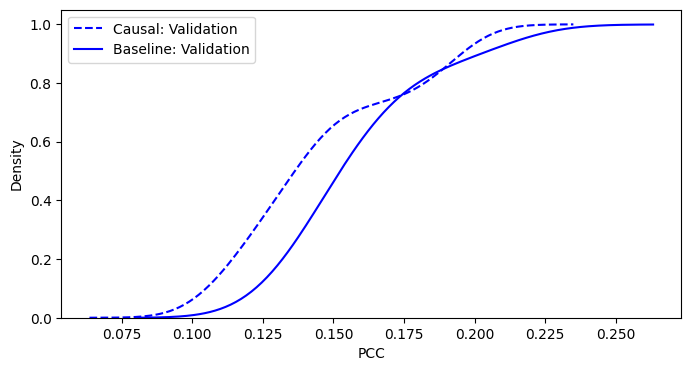

In [21]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
#sns.kdeplot(np.asarray(miss.flatten(r2_train_causalFS)),ls='--',c='k',label='Causal: Train',ax=ax)
#sns.kdeplot((r2_train_noFS),c='k',ls='-',label='Baseline: Train',ax=ax)
sns.kdeplot(np.asarray(miss.flatten(pcc_valid_causalFS)),ls='--',c='b',label='Causal: Validation',ax=ax,cumulative=True)
sns.kdeplot((pcc_valid_noFS),c='b',ls='-',label='Baseline: Validation',ax=ax,cumulative=True)
#sns.kdeplot(np.asarray(miss.flatten(r2_test_causalFS)),ls='--',c='r',label='Causal: Test',ax=ax,cumulative=True)
#sns.kdeplot((r2_test_noFS),c='r',ls='-',label='Baseline: Test',ax=ax,cumulative=True)
plt.legend(loc=2)
plt.xlabel('PCC')
#plt.xlim(-6,6)
plt.savefig('./figures/SHIPS_era5noassum_7fold_pcc_delv24.png',dpi=600)
plt.show()

## With Correlation

In [22]:
score_correlation = []
for seed in tqdm(seeds):
    correlation_results = performance_scores.scores_seeds(seed=seed,target=target,
                                                          lag=int(config_set['target_lag']),exp='SHIPSERA5_noassum').run_score_corrFS(shapez=np.asarray(miss.flatten(shapez_causalFS)).max())
    score_correlation.append(correlation_results)
    del correlation_results
    gc.collect()

  0%|          | 0/7 [00:00<?, ?it/s]

In [23]:
r2_train_corrFS, r2_valid_corrFS, r2_test_corrFS = [],[],[]
for i in range(len(score_correlation)):
    tempscore = score_correlation[i]['scoreboard']
    trains,valids,tests=[],[],[]
    for j in range(len(tempscore)):
        trains.append(tempscore[j]['train']['r2'])
        valids.append(tempscore[j]['valid']['r2'])
        tests.append(tempscore[j]['test']['r2'])
    r2_train_corrFS.append(trains)
    r2_valid_corrFS.append(valids)
    r2_test_corrFS.append(tests)
pcc_train_corrFS, pcc_valid_corrFS, pcc_test_corrFS = [],[],[]
for i in range(len(score_correlation)):
    tempscore = score_correlation[i]['scoreboard']
    trains,valids,tests=[],[],[]
    for j in range(len(tempscore)):
        trains.append(tempscore[j]['train']['r2_from_pcc'])
        valids.append(tempscore[j]['valid']['r2_from_pcc'])
        tests.append(tempscore[j]['test']['r2_from_pcc'])
    pcc_train_corrFS.append(trains)
    pcc_valid_corrFS.append(valids)
    pcc_test_corrFS.append(tests)

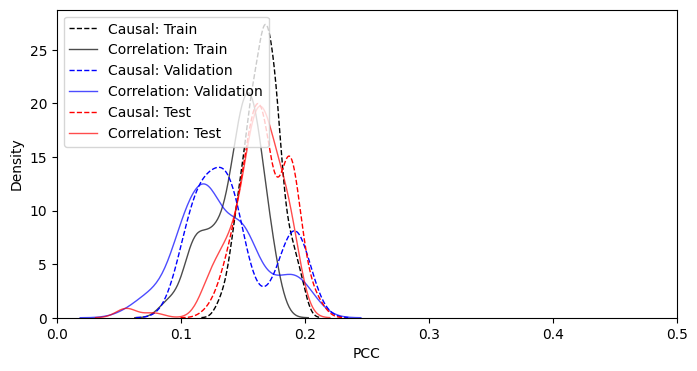

In [24]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
sns.kdeplot(np.asarray(miss.flatten(pcc_train_causalFS)),ls='--',lw=1,c='k',label='Causal: Train',ax=ax)
sns.kdeplot(np.asarray(miss.flatten(pcc_train_corrFS)),c='k',ls='-',lw=1,alpha=0.7,label='Correlation: Train',ax=ax)
sns.kdeplot(np.asarray(miss.flatten(pcc_valid_causalFS)),ls='--',lw=1,c='b',label='Causal: Validation',ax=ax)
sns.kdeplot(np.asarray(miss.flatten(pcc_valid_corrFS)),c='b',ls='-',lw=1,alpha=0.7,label='Correlation: Validation',ax=ax)
sns.kdeplot(np.asarray(miss.flatten(pcc_test_causalFS)),ls='--',lw=1,c='r',label='Causal: Test',ax=ax)
sns.kdeplot(np.asarray(miss.flatten(pcc_test_corrFS)),c='r',ls='-',lw=1,alpha=0.7,label='Correlation: Test',ax=ax)
plt.legend(loc=2)
plt.xlabel('PCC')
plt.xlim(0,0.5)
plt.savefig('./figures/SHIPSERA5noassum_pcc_corr_7fold_delv24.png',dpi=600)
plt.show()

## With Random Forest Feature selection

In [25]:
# Define the directory where the pickle files will be stored
import os
save_dir = '../2024_causalML_results/results/4/XAI_noassum/'

# Ensure the directory exists, if not, create it
os.makedirs(save_dir, exist_ok=True)

score_corr = []
for seed in tqdm(seeds):
    corr_results = performance_scores.scores_seeds(seed=seed, target=target, lag=int(config_set['target_lag']), exp='SHIPSERA5_noassum').run_score_XAIFS(shapez=np.asarray(miss.flatten(shapez_causalFS)).max())
    
    # Save the result to a pickle file for each seed with the specified path
    save_path = os.path.join(save_dir, f'xai_results_fold_{seed}.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump(corr_results, f)
    
    score_corr.append(corr_results)
    del corr_results
    gc.collect()
#RUN THIS ONLY ONCE TO CREATE RANDOM FOREST PKLS

  0%|          | 0/7 [00:00<?, ?it/s]

In [26]:
save_dir= '../2024_causalML_results/results/4/XAI_noassum/'
# List to store the loaded results
score_corr = []

# Load each pickle file and append to score_corr
for seed in seeds:
    file_path = os.path.join(save_dir, f'xai_results_fold_{seed}.pkl')
    with open(file_path, 'rb') as f:
        corr_results = pickle.load(f)
        score_corr.append(corr_results)

In [28]:
r2_train_XAIFS, r2_valid_XAIFS, r2_test_XAIFS = [],[],[]
for i in range(len(score_corr)):
    tempscore = score_corr[i]['scoreboard']
    trains,valids,tests=[],[],[]
    for j in range(len(tempscore)):
        trains.append(tempscore[j]['train']['r2'])
        valids.append(tempscore[j]['valid']['r2'])
        tests.append(tempscore[j]['test']['r2'])
    r2_train_XAIFS.append(trains)
    r2_valid_XAIFS.append(valids)
    r2_test_XAIFS.append(tests)

In [29]:
pcc_train_XAIFS, pcc_valid_XAIFS, pcc_test_XAIFS = [],[],[]
for i in range(len(score_corr)):
    tempscore = score_corr[i]['scoreboard']
    trains,valids,tests=[],[],[]
    for j in range(len(tempscore)):
        trains.append(tempscore[j]['train']['r2_from_pcc'])
        valids.append(tempscore[j]['valid']['r2_from_pcc'])
        tests.append(tempscore[j]['test']['r2_from_pcc'])
    pcc_train_XAIFS.append(trains)
    pcc_valid_XAIFS.append(valids)
    pcc_test_XAIFS.append(tests)

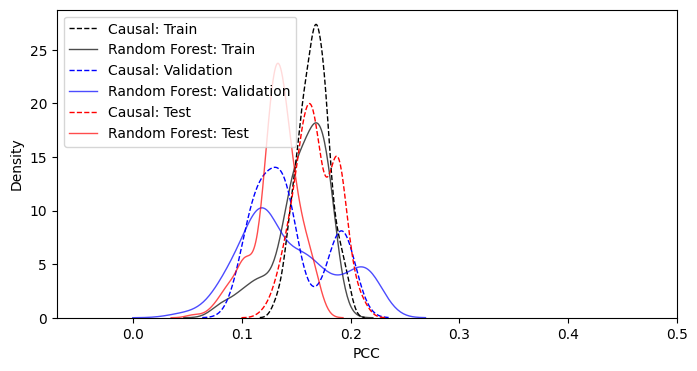

In [30]:
#with load_theme("scientific"):
fig,ax = plt.subplots(1,1,figsize=(8,4))
sns.kdeplot(np.asarray(miss.flatten(pcc_train_causalFS)),ls='--',lw=1,c='k',label='Causal: Train',ax=ax)
sns.kdeplot(np.asarray(miss.flatten(pcc_train_XAIFS)),c='k',ls='-',lw=1,alpha=0.7,label='Random Forest: Train',ax=ax)
sns.kdeplot(np.asarray(miss.flatten(pcc_valid_causalFS)),ls='--',lw=1,c='b',label='Causal: Validation',ax=ax)
sns.kdeplot(np.asarray(miss.flatten(pcc_valid_XAIFS)),c='b',ls='-',lw=1,alpha=0.7,label='Random Forest: Validation',ax=ax)
sns.kdeplot(np.asarray(miss.flatten(pcc_test_causalFS)),ls='--',lw=1,c='r',label='Causal: Test',ax=ax)
sns.kdeplot(np.asarray(miss.flatten(pcc_test_XAIFS)),c='r',ls='-',lw=1,alpha=0.7,label='Random Forest: Test',ax=ax)
plt.legend(loc=2)
plt.xlabel('PCC')
plt.xlim(-0.07,0.5)
plt.savefig('./figures/SHIPSera5noassum_pcc_randomforest_7fold_delv24.png')

In [31]:
import pickle

# === Bundle your arrays ===
pccbox_delv24 = {
    'train_noFS': pcc_train_noFS,
    'valid_noFS': pcc_valid_noFS,
    'test_noFS': pcc_test_noFS,

    'train_causalFS': pcc_train_causalFS,
    'valid_causalFS': pcc_valid_causalFS,
    'test_causalFS': pcc_test_causalFS,

    'train_corrFS': pcc_train_corrFS,
    'valid_corrFS': pcc_valid_corrFS,
    'test_corrFS': pcc_test_corrFS,

    'train_XAIFS': pcc_train_XAIFS,
    'valid_XAIFS': pcc_valid_XAIFS,
    'test_XAIFS': pcc_test_XAIFS,
}

# === Save to pickle ===
with open(f'box_plot_pkl/pccbox_era5noassum_{target}.pkl', 'wb') as f:
    pickle.dump(pccbox_delv24, f)

print(f"✅ Saved pccbox_era5noassum_{target}.pkl")


✅ Saved pccbox_era5noassum_delv24.pkl


In [32]:
import pickle

# === Bundle your arrays ===
r2box_delv120 = {
    'train_noFS': r2_train_noFS,
    'valid_noFS': r2_valid_noFS,
    'test_noFS': r2_test_noFS,

    'train_causalFS': r2_train_causalFS,
    'valid_causalFS': r2_valid_causalFS,
    'test_causalFS': r2_test_causalFS,

    'train_corrFS': r2_train_corrFS,
    'valid_corrFS': r2_valid_corrFS,
    'test_corrFS': r2_test_corrFS,

    'train_XAIFS': r2_train_XAIFS,
    'valid_XAIFS': r2_valid_XAIFS,
    'test_XAIFS': r2_test_XAIFS,
}

# === Save to pickle ===
with open(f'box_plot_pkl/r2box_era5wnoassum_{target}.pkl', 'wb') as f:
    pickle.dump(r2box_delv120, f)

print(f"✅ Saved r2box_era5noassum_{target}.pkl")

✅ Saved r2box_era5noassum_delv24.pkl


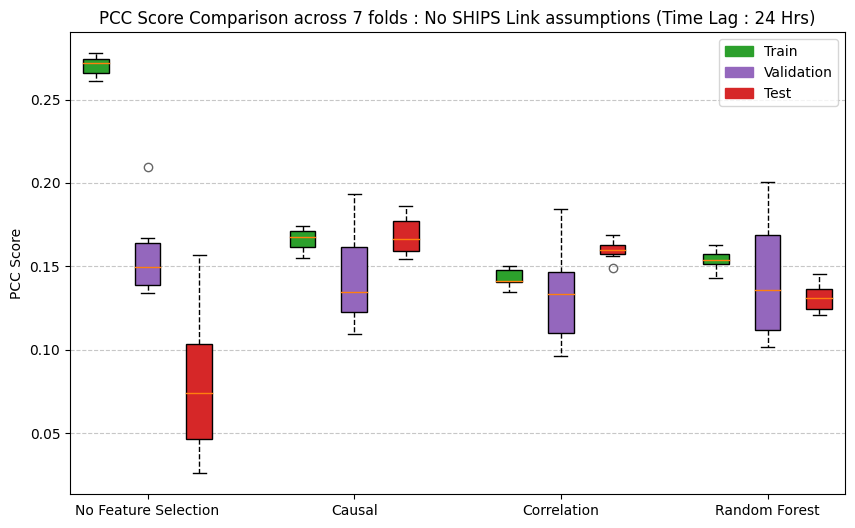

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Convert lists to numpy arrays and compute mean across inner lists
pcc_train_noFS = np.array(pcc_train_noFS)
pcc_valid_noFS = np.array(pcc_valid_noFS)
pcc_test_noFS = np.array(pcc_test_noFS)

pcc_train_causalFS = np.array([np.mean(fold) for fold in pcc_train_causalFS])
pcc_valid_causalFS = np.array([np.mean(fold) for fold in pcc_valid_causalFS])
pcc_test_causalFS = np.array([np.mean(fold) for fold in pcc_test_causalFS])

pcc_train_corrFS = np.array([np.mean(fold) for fold in pcc_train_corrFS])
pcc_valid_corrFS = np.array([np.mean(fold) for fold in pcc_valid_corrFS])
pcc_test_corrFS = np.array([np.mean(fold) for fold in pcc_test_corrFS])

pcc_train_XAIFS = np.array([np.mean(fold) for fold in pcc_train_XAIFS])
pcc_valid_XAIFS = np.array([np.mean(fold) for fold in pcc_valid_XAIFS])
pcc_test_XAIFS = np.array([np.mean(fold) for fold in pcc_test_XAIFS])

# Grouped box plots data
data = [
    pcc_train_noFS, pcc_valid_noFS, pcc_test_noFS,  # No FS
    None,  # Spacer
    pcc_train_causalFS, pcc_valid_causalFS, pcc_test_causalFS,  # Causal FS
    None,  # Spacer
    pcc_train_corrFS, pcc_valid_corrFS, pcc_test_corrFS,        # Correlation FS
    None,  # Spacer
    pcc_train_XAIFS, pcc_valid_XAIFS, pcc_test_XAIFS            # XAI FS
]

# Define colors (Train = Green, Validation = Purple, Test = Red)
colors = ["#2ca02c", "#9467bd", "#d62728", None,  # NoFS
          "#2ca02c", "#9467bd", "#d62728", None,  # Causal
          "#2ca02c", "#9467bd", "#d62728", None,  # Correlation
          "#2ca02c", "#9467bd", "#d62728"]        # XAI

# Create figure
plt.figure(figsize=(10, 6))

# Remove None values for box plot
valid_data = [d for d in data if d is not None]
valid_colors = [c for c in colors if c is not None]

# Create box plot
box = plt.boxplot(valid_data, patch_artist=True, positions=[1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 15])

# Apply colors
for patch, color in zip(box["boxes"], valid_colors):
    patch.set_facecolor(color)

# Customize x-axis labels
plt.xticks([2, 6, 10, 14], ["No Feature Selection", "Causal", "Correlation", "Random Forest"], fontsize=10)

# Outliers and whiskers styling
for flier in box["fliers"]:
    flier.set(marker="o", color="black", alpha=0.6)
for whisker in box["whiskers"]:
    whisker.set(color="black", linestyle="--")

# Labels and title
plt.ylabel("PCC Score")
plt.title("PCC Score Comparison across 7 folds : No SHIPS Link assumptions (Time Lag : 24 Hrs)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Custom legend
import matplotlib.patches as mpatches
legend_patches = [
    mpatches.Patch(color="#2ca02c", label="Train"),
    mpatches.Patch(color="#9467bd", label="Validation"),
    mpatches.Patch(color="#d62728", label="Test")
]
plt.legend(handles=legend_patches, loc="upper right")
plt.savefig('./figures/SHIPSera5noassum_pcc_comparison_allfold_delv24.png', dpi=300, bbox_inches='tight')
plt.show()


✅ Loaded all lead times: [24, 48, 72, 96, 120]
Total boxes: 20


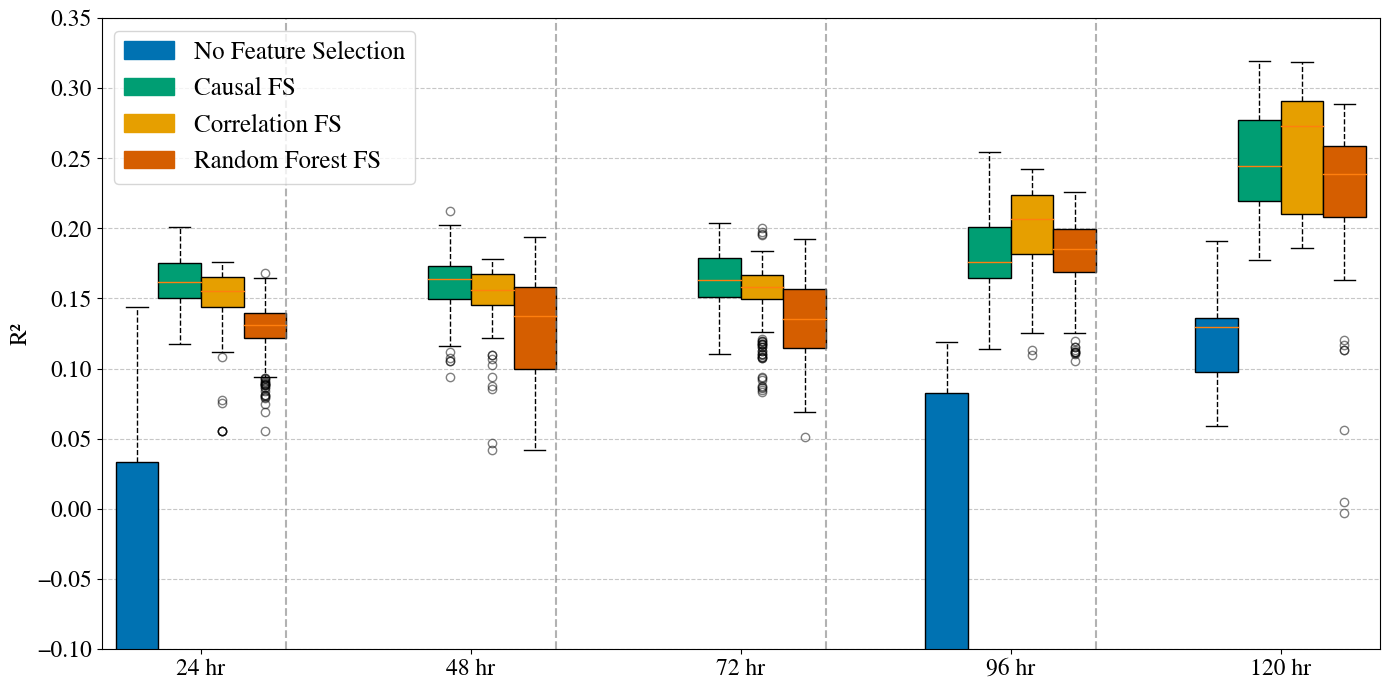

In [34]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === Use AMS-style serif font ===
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Nimbus Roman', 'Times', 'C059-Roman', 'P052-Roman', 'DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'stix'

# === Setup ===
lead_times = [24, 48, 72, 96, 120]
methods = ['noFS', 'causalFS', 'corrFS', 'XAIFS']
method_colors = [
    "#0072B2",  # Blue  (NoFS)
    "#009E73",  # Bluish Green (CausalFS)
    "#E69F00",  # Orange (CorrelationFS)
    "#D55E00",  # Vermillion (XAIFS)
]

# === 1. Load and collect test sets for each lead time ===
box_data = []  # Each item will be a list of test sets for each method per lead time
for lt in lead_times:
    with open(f'box_plot_pkl/r2box_era5wnoassum_delv{lt}.pkl', 'rb') as f:
        r2box = pickle.load(f)
    for method in methods:
        arr = np.asarray(r2box[f"test_{method}"]).ravel()
        box_data.append(arr)

print(f"✅ Loaded all lead times: {lead_times}")
print(f"Total boxes: {len(box_data)}")

# === 2. Compute positions grouped by lead time ===
positions = []
start = 1
inner_gap = 0.6
group_gap = 2

for _ in lead_times:
    group_pos = [start + inner_gap * j for j in range(len(methods))]
    positions.extend(group_pos)
    start = group_pos[-1] + group_gap

colors = method_colors * len(lead_times)

# === 3. Plot ===
plt.figure(figsize=(14, 7))
box = plt.boxplot(box_data, patch_artist=True, positions=positions, widths=0.6)

# Color each box
for patch, color in zip(box["boxes"], colors):
    patch.set_facecolor(color)

for whisker in box["whiskers"]:
    whisker.set(color="black", linestyle="--")
for flier in box["fliers"]:
    flier.set(marker="o", color="black", alpha=0.5)

# Group centers for x-axis labels
group_centers = []
for i in range(len(lead_times)):
    group = positions[i*len(methods):(i+1)*len(methods)]
    group_centers.append(np.mean(group))

plt.xticks(group_centers, [f"{lt} hr" for lt in lead_times], fontsize=17)
plt.ylabel("R²", fontsize=17)
plt.yticks(fontsize=17)
plt.ylim(-0.1, 0.35)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Vertical separators
for g in range(1, len(lead_times)):
    split_pos = positions[g*len(methods) - 1] + inner_gap/2
    plt.axvline(x=split_pos, color='grey', linestyle='--', alpha=0.6)

# Legend
legend_patches = [
    mpatches.Patch(color=method_colors[0], label="No Feature Selection"),
    mpatches.Patch(color=method_colors[1], label="Causal FS"),
    mpatches.Patch(color=method_colors[2], label="Correlation FS"),
    mpatches.Patch(color=method_colors[3], label="Random Forest FS"),
]
plt.legend(handles=legend_patches, loc="upper left", fontsize=18)

plt.tight_layout()
plt.savefig('./figures/grouped_boxplot_noassum_r2_test_vs_leadtime.png', dpi=300)
plt.show()
